In [8]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt


img1 = cv.imread('./data/Mesona1.JPG',0)  #queryimage # left image
img2 = cv.imread('./data/Mesona2.JPG',0) #trainimage # right image

sift = cv.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

bf = cv.BFMatcher(cv.NORM_L2)

# For each local descriptor des1, find 2 best correspondence from des 2
matches = bf.knnMatch(des1, des2, k=2)  # Think of it just finding a cluster of ssd.

In [9]:
good = []
pts1 = []
pts2 = []

mask = [[0,0]] * len(matches)

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.75*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        mask[i] = [1,0]


pts1 = np.int32(pts1)
pts2 = np.int32(pts2)


F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_RANSAC, param1=3)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]


In [10]:


def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

[[ 1.0564647e-01 -9.9440378e-01  2.2787831e+02]
 [ 1.0745586e-01 -9.9420989e-01  2.1853267e+02]
 [ 1.1168154e-01 -9.9374408e-01  1.9669676e+02]
 ...
 [ 7.1953028e-02 -9.9740803e-01  4.0144089e+02]
 [ 1.0872551e-01 -9.9407178e-01  2.1197330e+02]
 [ 8.6409405e-02 -9.9625969e-01  3.2708099e+02]]


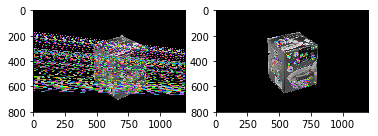

True

In [12]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)

print(lines1)

img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)


fig = plt.figure()
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img6)

plt.show()

fig.savefig('test.pdf', bbox_inches='tight')
cv.imwrite('test1.png', img5)
cv.imwrite('test2.png', img6)